# EHealth 705

## Python Tutorial: Categorical Data Analysis.

###  TA: Shirin Shahabinejad : [shahas8@mcmaster.ca](mailto:shahas8@mcmaster.ca)

## Table of Contents
1. [Overview of categorical data analysis](#categorical)
2. [Conducting Chi-Square tests in Python](#Chi-Square)
3. [ANOVA](#ANOVA)
4. [Practical Example: Analyze a categorical dataset from eHealth.](#Practical_exercise)
5. [Reviewing and interpreting test results](#TestResult)
6. [Q&A and Troubleshooting](#QA-and-Troubleshooting)
7. [Assignment: Analyze categorical health data and apply ANOVA](#Assignment)



#### Date : Mar  14th, 2024

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import scipy.stats as stats

from scipy.stats import f_oneway
from scipy.stats import chi2

from statsmodels.formula.api import ols      # For n-way ANOVA
from statsmodels.stats.anova import anova_lm # For n-way ANOVA
from   scipy.stats import chi2_contingency   # For Chi-Sq 

# Overview of categorical data analysis <a id="categorical"></a>



Categorical data analysis is a branch of statistics that deals with datasets where the observations can be divided into distinct categories. It involves analyzing and drawing conclusions from data that can be classified into non-numeric categories such as gender, race, or a yes/no response. Here's an overview:

Types of Categorical Data:
- Nominal Data: Categories with no intrinsic order. For example, hair color, zip code, or nationality.
- Ordinal Data: Categories with a natural order but not evenly spaced. For example, educational level, business class, or service ratings.




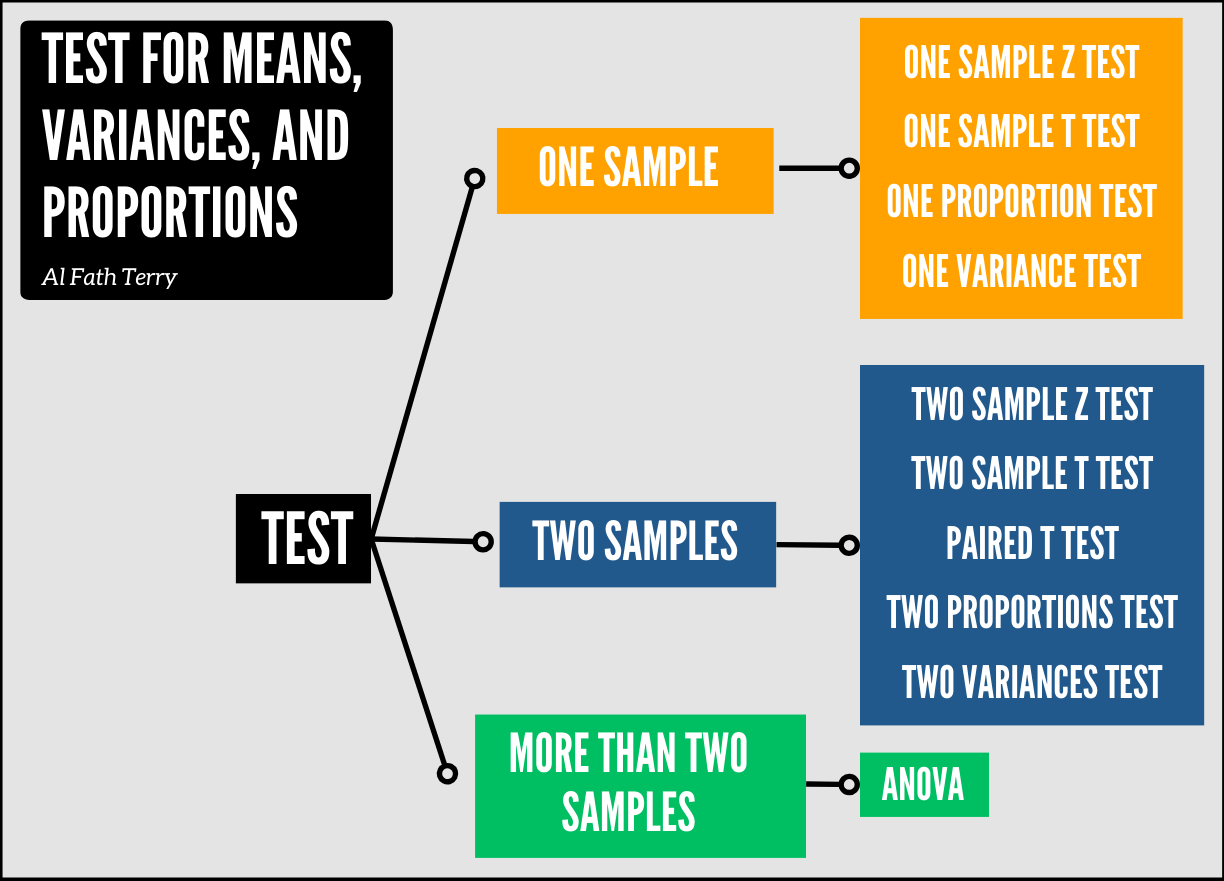

In a data sample the number of data falling into a particular group is called the frequency, so the analysis of categorical data is the analysis of frequencies. When two or more groups are compared the data are often shown in the form of a frequency table, sometimes also called contingency table.If we have only one factor (i.e., a table with only one row), the analysis options are somewhat limited. Some of the most common statistical methods used for analysis of the frequency:-


- Chi Square Test :- This statistical tests checks that the entries in the individual cells in a frequency table all come from the same distribution.it checks the null hypothesis H0 that the results are independent of the row or column in which they appear. The alternative hypothesis Ha does not specify the type of association, so close attention to the data is required to interpret the information provided by the test.

- Fisher's Exact Test :- The chi-square test is approximate, the Fisher’s Exact Test is an exact test. It is computationally more expensive and intricate than the chi-square test, and was originally used only for small sample numbers. It is more advisable to use.

- McNemar's Test :- This is a matched pair test for 2 * 2 Tables. If we want to compare the results of doctor when checking the same patients, we would use this test.

- Cochran's Q Test :- It is an extension of the MeNemar's tests for related samples that provides a method for testing for differences between three or more matched/Paired sets of frequencies or proportion




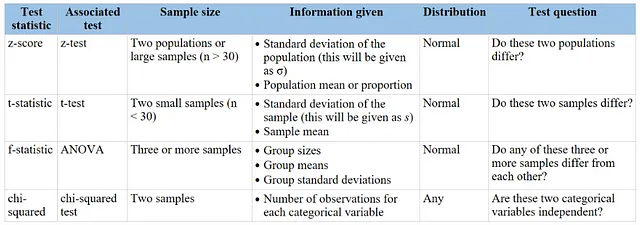


Example: 
    
    
       
    the cards data frame contains three variables, an id variable that assigns a unique identifier to each participant, and the two variables choice_1 and choice_2 that indicate the card suits that people chose. Here’s the first few entries in the data frame:



In [65]:
df = pd.read_csv('https://raw.githubusercontent.com/ethanweed/pythonbook/main/Data/cards.csv')
df

,id,choice_1,choice_2
0,subj1,spades,clubs
1,subj2,diamonds,clubs
2,subj3,hearts,clubs
3,subj4,spades,clubs
4,subj5,hearts,spades
...,...,...,...
195,subj196,spades,hearts
196,subj197,hearts,spades
197,subj198,clubs,clubs
198,subj199,spades,hearts


In [67]:
observed = df['choice_1'].value_counts()
observed

hearts      64
diamonds    51
spades      50
clubs       35
Name: choice_1, dtype: int64

our research hypothesis is that "people don't choose cards randomly". 
What we're going to want to do now is translate this into some statistical hypotheses, and construct a statistical test of those hypotheses. The test that I'm going to describe to you is Pearson's $\chi^2$ goodness of fit test, and as is so often the case, we have to begin by carefully constructing our null hypothesis. In this case, it's pretty easy. First, let's state the null hypothesis in words:


$H_0$ : All four suits are chosen with equal probability

 If the null hypothesis is true, then each of the four suits has a 25% chance of being selected
 
* $H_0$ : All four suits are chosen with equal probability
* $H_1$ : At least one of the suit-choice probabilities isn't 25 and the "mathematician friendly" version is



$$
\begin{aligned}
& H_0: P=(.25, .25, .25, .25) \\
& H_1: P \neq(.25, .25, .25, .25)
\end{aligned}
$$

In [26]:
# make dictionary of values
dict = {'hearts' : .25,
        'diamonds' : .25,
        'spades' : .25,
        'clubs': .25}
   
# create series from dictionary
probabilities = pd.Series(dict)
probabilities

hearts      0.25
diamonds    0.25
spades      0.25
clubs       0.25
dtype: float64

At this point, we have our observed frequencies and a collection of probabilities $P$ corresponding the null hypothesis that we want to test. We've stored these in Python as the corresponding variables observed and probabilities. What we want to do now is construct a test of the null hypothesis. As always, if we want to test $H_0$ against $H_1$, we're going to need a test statistic. The basic trick that a goodness of fit test uses is to construct a test statistic that measures how "close" the data are to the null hypothesis. If the data don't resemble what you'd "expect" to see if the null hypothesis were true, then it probably isn't true. Okay, if the null hypothesis were true, what would we expect to see? Or, to use the correct terminology, what are the **expected frequencies*? There are $N=200$ observations, and (if the null is true) the probability of any one of them choosing a heart is $P_3=.25$, so I guess we're expecting $200 \times .25=50$ hearts.

In [27]:
N = 200 #sample size
expected = N * probabilities
expected

hearts      50.0
diamonds    50.0
spades      50.0
clubs       50.0
dtype: float64

\begin{array}{llllll} 
& & clubs & diamond & hearts & spades \\
\hline \text { expected frequency } & E_i & 50 & 50 & 50 & 50 \\
\hline \text { observed frequency } & O_i & 35 & 51 & 64 & 50 \\
\hline \text { difference score } & O_i-E_i & -15 & 1 & 14 & 0
\end{array}

In [28]:
observed-expected

hearts      14.0
diamonds     1.0
spades       0.0
clubs      -15.0
dtype: float64

The formula for this statistic looks remarkably similar to the Python command. If we let $k$ refer to the total number of categories (i.e., $k=4$ for our cards data), then the $X^2$ statistic is given by:
$$
X^2=\sum_{i=1}^k \frac{\left(O_i-E_i\right)^2}{E_i}
$$

Intuitively, it's clear that if $X^2$ is small, then the observed data $O_i$ are very close to what the null hypothesis predicted $E_i$, so we're going to need a large $X^2$ statistic in order to reject the null. As we've seen from our calculations, in our cards data set we've got a value of $X^2=8.44$. So now the question becomes, is this a big enough value to reject the null?

In [37]:
sum((observed - expected)**2/expected)


8.44

In [43]:
round(chi2.ppf(0.95, 3),2)

7.81

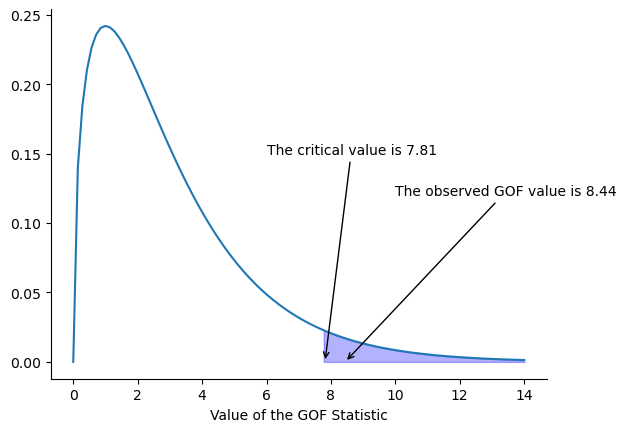

In [42]:
x = np.linspace(0, 14, 100)

y = chi2.pdf(x, df=3)

df = pd.DataFrame(
    {'y': y,
     'x': x
    }) 

fig = sns.lineplot(x= "x", y= "y",
             data=df)
critical_value = chi2.ppf(0.95, 3)
fig.fill_between(x, 0, y, where = x > critical_value-0.1, color = 'blue', alpha = 0.3)

fig.annotate("The observed GOF value is 8.44", xy=(8.44, 0), xytext=(10, 0.12), arrowprops={"arrowstyle":"->", "color":"black"})
fig.annotate("The critical value is 7.81", xy=(critical_value, 0), xytext=(6, 0.15), arrowprops={"arrowstyle":"->", "color":"black"})
fig.set(xlabel = 'Value of the GOF Statistic', ylabel='')

sns.despine()

In [45]:
stats.chisquare(f_obs = observed, f_exp = expected)

Power_divergenceResult(statistic=8.44, pvalue=0.0377418520240214)

So, in this case we would reject the null hypothesis, since $p<.05$. And that's it, basically. You now know "Pearson's $\chi^2$ test for the goodness of fit". Lucky you.

# Conducting Chi-Square tests in Python <a id="Chi-Square"></a>

The Chi-Square test is a statistical method used to determine if there's a significant difference between the expected frequencies and the observed frequencies in one or more categories. It's commonly used in two scenarios:

1. Goodness of Fit Test: This checks whether the observed sample distribution matches an expected probability distribution. It's applied to a single categorical variable from a single population. For instance, it can test if the number of customers who prefer each of several product types is consistent with company projections.
2. Test of Independence: This assesses whether unpaired observations on two variables, expressed in a contingency table, are independent of each other. For example, it can examine if there's an association between gender and preference for a certain product.




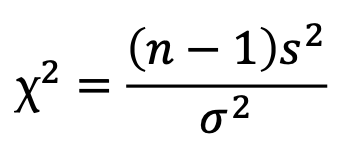


In both tests, you calculate the Chi-Square statistic using the formula $\chi^2=\sum \frac{(O-E)^2}{E}$, where $O$ represents the observed frequency, and $E$ is the expected frequency. You then compare this statistic to a Chi-Square distribution to determine the p-value. If the p-value is less than the chosen significance level (typically 0.05 ), you reject the null hypothesis, suggesting a statistically significant difference or association.

These tests are powerful tools in research for analyzing categorical data and making inferences about populations based on sample data.

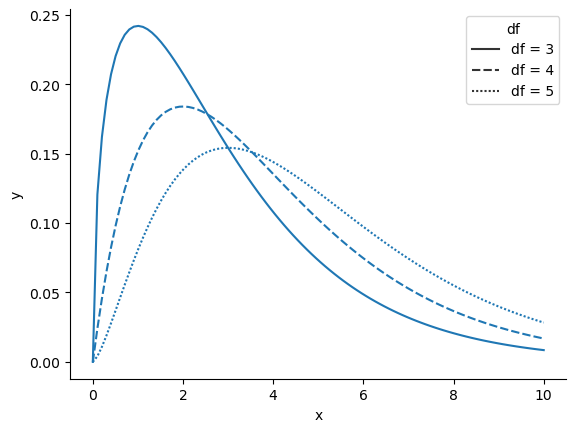

In [39]:
## degrees of freedom

x = np.linspace(0, 10, 100)

y3 = chi2.pdf(x, df=3)
y4 = chi2.pdf(x, df=4)
y5 = chi2.pdf(x, df=5)
labels = ['df = 3']*len(x) + ['df = 4']*len(x) + ['df = 5']*len(x)
y = list(y3)+list(y4)+list(y5)
x = list(x)*3

df = pd.DataFrame(
    {'y': y,
     'x': x,
     'df': labels
    }) 

fig = sns.lineplot(x= "x", y= "y",
             style="df",
             data=df)

sns.despine()

### Chi-Squared Test Of Independence


The chi-squared test of independence allows you to test whether there is a relationship between two categorical variables. But, it does not tell you the direction or the size of the relationship. The test is based on the comparison between the observed frequencies in a contingency table and the frequencies that would be expected if the variables were independent.

The assumptions of the Chi-Squared include

- The data in the cells should be frequencies, or counts of cases rather than percentages or some other transformation of the data.
- The levels (or categories) of the variables are mutually exclusive.
- Your two variables should be measured at an ordinal or nominal level (i.e., categorical data).


A chi-square test of independence is used to determine whether or not there is a significant association between two categorical variables.

* H0: The two variables are independent.
* H1: The two variables are not independent.

Example:
                        
                        
    We want to determine if there is any association between Gender and Color preference. The level of significance is 0.05.
\begin{array}{rrrr} 
& \text { Blue } & \text { Green } & \text { Pink } \\
\hline \text { Boys } & 100 & 150 & 20 \\
\text { Girls } & 20 & 30 & 180
\end{array}

In [23]:
data = [[100, 150, 20],
        [20, 30, 180]]


#perform the Chi-Square Test of Independence
stats.chi2_contingency(data, correction=True)

Chi2ContingencyResult(statistic=259.79602791196993, pvalue=3.8548663789964316e-57, dof=2, expected_freq=array([[ 64.8,  97.2, 108. ],
       [ 55.2,  82.8,  92. ]]))


Since the p-value (3.854e-57) of the test is less than 0.05, we reject the null hypothesis. This means that we have sufficient evidence to say that there is a relationship between gender and favorite color.


**The Chi-Square test is a statistical test used to examine the association or independence between two categorical variables.**

Chi-Square tests are often used when you have categorical data and want to determine if there is a relationship between two variables.

There are different variations of the Chi-Square test, such as the Chi-Square test for independence (to test if variables are independent) and the Chi-Square goodness-of-fit test (to test if observed frequencies fit an expected distribution).


### Chi-Squared Goodness Of Fit Test

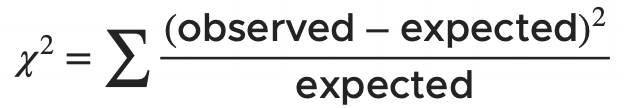

Chi-square goodness of fit test is used to determine whether or not a categorical variable follows a hypothesized distribution.

* H0: A variable follows a hypothesized distribution.
* H1: A variable does not follow a hypothesized distribution.

Example: 

    The following table gives the number of aircraft accidents that occurs during the various days of the week. Find whether the accidents are uniformly distributed over the week. The level of significance is 0.05.


    week      = ['Sun','Mon','Tue','Wed','Thurs','Fri','Sat']

    accidents = [14, 16, 8, 12, 11, 9, 14]

* H0: The accidents are uniformly distributed over the week.
* H1: The accidents are not uniformly distributed over the week

In [37]:
observed = [14, 16, 8, 12, 11, 9, 14]
expected_value = 0
for i in observed:
    expected_value = i + expected_value
expected_value = expected_value/len(observed)

expected_data = [int(expected_value) for i in range(len(observed))]


#expected = [12, 12, 12, 12, 12, 12, 12]




In [28]:
statistic, pvalue = stats.chisquare(f_obs=observed, 
                                        f_exp= expected)
statistic, pvalue

(4.166666666666667, 0.6541333169963821)

The Chi-Square test statistic is found to be 4.166 and the corresponding p-value is 0.654.

Since the p-value (0.654) is not less than 0.05, we fail to reject the null hypothesis. That is the air accidents are uniformly distributed over the week.

We can go a bit further and calculate the critical value.

In [33]:
alpha = 0.05

critical_value = chi2.ppf(q=1-alpha, df=len(observed)-1)
print('critical_value:',critical_value)


if statistic < critical_value:
    print('We fail to reject the null hypothesis')
else:
    print('We reject null hypothesis')

critical_value: 12.591587243743977
We fail to reject the null hypothesis


# ANOVA [ANalysis Of VAriance] <a id="ANOVA"></a>

An ANOVA is a statistical test that is used to determine whether or not there is a statistically significant difference between the means of three or more independent groups.

A one-way ANOVA (“analysis of variance”) compares the means of three or more independent groups to determine if there is a statistically significant difference between the corresponding population means.

The main idea of ANOVA is to partition the variance (sums of squares) into several components. For example, in one-way ANOVA:
$$
\begin{array}{r}
S S_{\text {total }}=S S_{\text {effect }}+S S_{\text {error }} \\
S S_{\text {total }}=\sum_i \sum_j\left(Y_{i j}-\bar{Y}\right)^2 \\
S S_{\text {effect }}=\sum_i n_i\left(\overline{Y_i}-\bar{Y}\right)^2 \\
S S_{\text {error }}=\sum_i \sum_j\left(Y_{i j}-\bar{Y}_i\right)^2
\end{array}
$$

where $i=1, \ldots, r ; j=1, \ldots, n_i, r$ is the number of groups, and $n_i$ the number of observations for the $i$ th group.

The F-statistics is then defined as:
$$
F^*=\frac{M S_{\text {effect }}}{M S_{\text {error }}}=\frac{S S_{\text {effect }} /(r-1)}{S S_{\text {error }} /\left(n_t-r\right)}
$$

and the $p$-value can be calculated using a F-distribution with $r-1, n_t-1$ degrees of freedom.

One-Way ANOVA: Assumptions

* Normality — Each sample was drawn from a normally distributed population.
* Equal Variances — The variances of the populations that the samples come from are equal.
* Independence — The observations in each group are independent of each other and the observations within groups were obtained by a random sample.


$\mathrm{H0}: \mu 1=\mu 2=\mu 3=\ldots=\mu \mathrm{k}$ (all the population means are equal)

$\mathrm{H1}$ : at least one population mean is different from the rest






Example: 

    you want to find out if the beverage that people drink affects their reaction time. So, you set up an experiment with three groups of people. The 1st group gets water to drink, the second gets juice and the third gets coffee. The level of significance is 0.05.
    
\begin{aligned}
& \text { group_water }=[29,30,31,31,29] \\
& \text { group_juice }=[28,29,27,30,29] \\
& \text { group_coffee }=[25,28,29,27,29]
\end{aligned}
    
    
(If you only had 2 groups, you could have used t-test).

Given that you have 3 groups, you ought to use analysis of variance.

The variation of scores is made up of two parts.

* The variation within each group
* The variation between the groups.


**F = (between groups variance)/(within groups variance)**

In [34]:
group_water  = [29, 30, 31, 31, 29]
group_juice  = [28, 29, 27, 30, 29]
group_coffee = [25, 28, 29, 27, 29]

In [39]:
print(np.std(group_water))
print(np.std(group_juice)) 
print(np.std(group_coffee)) 

f_oneway(group_water, group_juice, group_coffee)


0.8944271909999159
1.019803902718557
1.4966629547095764


F_onewayResult(statistic=4.2745098039215685, pvalue=0.03965891577699055)

### Two-Way ANOVA

You should use a two-way ANOVA when you’d like to know how two factors affect a response variable and whether or not there is an interaction effect between the two factors on the response variable.

For the results of a two-way ANOVA to be valid, the following assumptions should be met:

* Normality — The response variable is approximately normally distributed for each group.
* Equal Variances — The variances for each group should be roughly equal.
* Independence — The observations in each group are independent of each other and the observations within groups were obtained by a random sample.

Example:

    A researcher wants to know whether test scores are influenced by Gender or Age or both. She collects information with regards to this experiment. The data she collected is as follows. The level of significance is 0.05.
    
\begin{array}{rrrr} 
& \text { Gender } & \text { Age } & \text { Score } \\
\hline \mathbf{0} & \text { Boys } & 10 & 4 \\
\mathbf{1} & \text { Boys } & 10 & 6 \\
\mathbf{3} & \text { Boys } & 10 & 8 \\
\mathbf{4} & \text { Girls } & 10 & 4 \\
\mathbf{5} & \text { Girls } & 10 & 8 \\
\mathbf{6} & \text { Boys } & 11 & 6 \\
\mathbf{7} & \text { Boys } & 11 & 6 \\
\mathbf{8} & \text { Boys } & 11 & 9 \\
\mathbf{9} & \text { Girls } & 11 & 7 \\
\mathbf{1 0} & \text { Girls } & 11 & 10 \\
\mathbf{1 1} & \text { Girls } & 11 & 13 \\
\mathbf{1 2} & \text { Boys } & 12 & 8 \\
\mathbf{1 3} & \text { Boys } & 12 & 9 \\
\mathbf{1 4} & \text { Boys } & 12 & 13 \\
\mathbf{1 5} & \text { Girls } & 12 & 12 \\
\mathbf{1 6} & \text { Girls } & 12 & 14 \\
\mathbf{1 7} & \text { Girls } & 12 & 16
\end{array}

In [41]:
data = pd.DataFrame({'Gender': np.tile(np.repeat(['Boys', 'Girls'], 3),3),
                   'Age': np.repeat(['10', '11', '12'], 6),
                   'Score': [4,6,8,4,8,9,
                             6,6,9,7,10,13,
                             8,9,13,12,14,16
                   
                              ]
                  })

In [42]:
model = ols('Score ~ C(Age) + C(Gender) + C(Gender) * C(Age)', 
                                             data = data).fit()               
anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Age),93.0,2.0,8.205882,0.005677
C(Gender),32.0,1.0,5.647059,0.034994
C(Gender):C(Age),7.0,2.0,0.617647,0.555502
Residual,68.0,12.0,NaN,NaN


Since the p-value of gender (0.035) is less than .05, this means that gender has significant impact on the test scores.

Since the p-value of age (0.006) is less than .05, this means that age has significant impact on the test scores.

Since the p-value of age and gender (0.556) is greater than .05, we can say that gender and age (combined) interaction has no significant impact on the test scores.

**ANOVA is commonly used when you have a continuous dependent variable and one or more categorical independent variables with multiple levels. The test compares the means across the groups and calculates an F-statistic and p-value to determine if the differences are statistically significant.**

# Practical: Analyze a categorical dataset from eHealth.<a id="Practical_exercise"></a>


#### Datasets
 - [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)
 - [Health Insurance Dataset](https://www.kaggle.com/datasets/shivadumnawar/health-insurance-dataset/data)


# Reviewing and interpreting test results<a id="TestResult"></a>


In [78]:
# Load the dataset
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [75]:
df.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [70]:
df.describe().T.style.background_gradient(cmap='Greens').format("{:.2f}")


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.00,3.85,3.37,0.00,1.00,3.00,6.00,17.00
Glucose,768.00,120.89,31.97,0.00,99.00,117.00,140.25,199.00
BloodPressure,768.00,69.11,19.36,0.00,62.00,72.00,80.00,122.00
SkinThickness,768.00,20.54,15.95,0.00,0.00,23.00,32.00,99.00
Insulin,768.00,79.80,115.24,0.00,0.00,30.50,127.25,846.00
BMI,768.00,31.99,7.88,0.00,27.30,32.00,36.60,67.10
DiabetesPedigreeFunction,768.00,0.47,0.33,0.08,0.24,0.37,0.63,2.42
Age,768.00,33.24,11.76,21.00,24.00,29.00,41.00,81.00
Outcome,768.00,0.35,0.48,0.00,0.00,0.00,1.00,1.00


In [73]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [79]:
df[[ 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']]=df[[ 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']].replace(0, np.NaN)



df.isnull().any()




Pregnancies                 False
Glucose                      True
BloodPressure                True
SkinThickness                True
Insulin                      True
BMI                          True
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [80]:
#Replacing the null values with the mean and median respectively


df['Glucose'].fillna(df['Glucose'].mean(), inplace = True)
df['BloodPressure'].fillna(df['BloodPressure'].mean(),inplace=True)
df['SkinThickness'].fillna(df['SkinThickness'].median(),inplace=True)
df['Insulin'].fillna(df['Insulin'].median(),inplace=True)
df['BMI'].fillna(df['BMI'].median(),inplace=True)


df.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

## Recap
### One Sample T Test 

If we have to check the mean value of the normally distributed data against a reference value, we use the one sample t test which is based on the $t$ - distribution.

If the mean and the standard deviation of a normally distributed population is known, we could calculate the corresponding standard error, and use values from the normal distribution to determine how likely it is to find a certain value.


Formulate the null hypothesis
- H0 - The difference in mean between sample BP column and population mean for BP is a statistical fluctuation. The given data represents the population distribution on the BP column
- H1 - The difference in mean between sample BP column and population mean is significant. The difference is too high to be result of statistical fluctuation
- If statistical tests result in rejecting ${H0}$, then building a model on the given sample data and expecting it to generalize may be a mistake

In [15]:
Mu = 72.4   
# Std = ?  Population standard deviatin is unknown

x = df['BloodPressure']  # Storing values in a list to avoid long names
est_pop_std = np.sqrt(np.sum(abs(x - x.mean())**2) / (df.size - 1))     #  sqrt(sum(xi - Xbar)^2 / (n -1))

sample_avg_bp =(df['BloodPressure']).mean()

std_error_bp = est_pop_std / np.sqrt(df.size) # Standard dev of the sampling mean distribution... estimated from population

T_Statistic = (( sample_avg_bp - Mu) / std_error_bp)

pvalue = st.t.sf(np.abs(T_Statistic), df.size-1)*2
print("Estimated Pop Stand Dev" , est_pop_std)
print("Sample Avg BP : " , sample_avg_bp)
print("Standard Error: " , std_error_bp)
print("T Statistic" , T_Statistic)
print("Pval" , pvalue)

if pvalue > 0.05:
    print('Samples are likely drawn from the same distributions (fail to reject H0)')
else:
    print('Samples are likely drawn from different distributions (reject H0)')


Estimated Pop Stand Dev 4.029780981170755
Sample Avg BP :  72.40518417462482
Standard Error:  0.048470731963628534
T Statistic 0.1069547418575378
Pval 0.9148279889577062
Samples are likely drawn from the same distributions (fail to reject H0)


### Two Sample T Test 

If the groups come from two different populations (e.g. two different species, or people from two separate cities), perform a two-sample t-test (a.k.a. independent t-test).An unpaired t-test, or t-test for two independent groups, compares two groups. An example would be the comparison of the effect of two medications given to two different groups of patients.



In [20]:
df_mod = df.copy()


df_mod['BloodPressure'] = df_mod['BloodPressure'].mask(df['BloodPressure'] == 0,df['BloodPressure'].median())

In [21]:
from scipy.stats import ttest_ind

stat, pvalue = ttest_ind(df_mod['BloodPressure'] , df['BloodPressure'])
print("compare means", df_mod['BloodPressure'].mean() ,df['BloodPressure'].mean())
print("Tstatistic , Pvalue", stat, pvalue)

if pvalue > 0.05:
    print('Samples are likely drawn from the same distributions (fail to reject H0)')
else:
    print('Samples are likely drawn from different distributions (reject H0)')

compare means 72.40518417462482 72.40518417462482
Tstatistic , Pvalue 0.0 1.0
Samples are likely drawn from the same distributions (fail to reject H0)


### Categorical Data Analysis

In [3]:
# Load the dataset
Insurance_df = pd.read_csv('insurance.csv')
Insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [46]:
table = pd.crosstab(Insurance_df['sex'], Insurance_df['smoker'])
print(table)

smoker   no  yes
sex             
female  547  115
male    517  159


In [47]:
# observed values

observed_values = table.values
print('observed values:\n {}'.format(observed_values))

observed values:
 [[547 115]
 [517 159]]


In [48]:
value = stats.chi2_contingency(table)
value

Chi2ContingencyResult(statistic=7.39291081459996, pvalue=0.006548143503580696, dof=1, expected_freq=array([[526.43348281, 135.56651719],
       [537.56651719, 138.43348281]]))

In [49]:
expected_values = value[3]
expected_values

array([[526.43348281, 135.56651719],
       [537.56651719, 138.43348281]])

In [52]:
#to determine the degree of freedom manually!

rows = len(table.iloc[0:2,])
columns = len(table.iloc[0,0:2])

DOF = (rows-1) * (columns-1)
print('Degree of Freedom: {}'.format(DOF))

Degree of Freedom: 1


In [73]:
# Calculate Chi-Square statistic
observed = np.array(observed)
expected = np.array(expected)

chi_square_stat = np.sum((observed - expected)**2 / expected)


# critical value

alpha = 0.05
critical_value = chi2.ppf(q=1-alpha, df =DOF)

# p value
p_value = 1 - chi2.cdf(x=chi_square_stat, df=DOF)

print('p-value: {}'.format(p_value))
print('Significance level: {}'.format(alpha))
print('Degree of Freedom: {}'.format(DOF))



if chi_square_stat >= critical_value:
    print('Reject Null Hypothesis (H0)')
else:
    print('Retain Null Hypothesis (H0)')
    
if p_value <= alpha:
    print('Reject Null Hypothesis (H0)')
else:
    print('Retain Null Hypothesis (H0)')

p-value: 0.041226833337163815
Significance level: 0.05
Degree of Freedom: 1
Reject Null Hypothesis (H0)
Reject Null Hypothesis (H0)


### Analyze the impact of the 'Region' on the 'charges'

In [85]:
Insurance_df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [86]:
Insurance_df.groupby('region')['charges'].mean()

region
northeast    13406.384516
northwest    12417.575374
southeast    14735.411438
southwest    12346.937377
Name: charges, dtype: float64

In [53]:
# ONE WAY ANOVA

# Define your significance level
alpha = 0.05

# Group data by 'region' and collect 'charges' in lists, then perform ANOVA
grouped_data = Insurance_df.groupby('region')['charges'].apply(list)
f_value, p_value = stats.f_oneway(*grouped_data)

print('F-value:', f_value)
print('P-value:', p_value)

# Compare the p-value against the significance level
if p_value < alpha:
    print('We reject the null hypothesis, indicating at least one group mean is significantly different.')
else:
    print('We fail to reject the null hypothesis, indicating no significant difference between the group means.')


F-value: 2.96962669358912
P-value: 0.0308933560705201
We reject the null hypothesis, indicating at least one group mean is significantly different.


In [61]:
## Anova Test Using Penguin
#!pip install pingouin

In [54]:
import pingouin as pg
AoV = pg.anova(dv ='charges', between = 'region', data =Insurance_df, detailed=True)
AoV

,Source,SS,DF,MS,F,p-unc,np2
0,region,1.300760e+09,3,4.335866e+08,2.969627,0.030893,0.006634
1,Within,1.947735e+11,1334,1.460071e+08,NaN,NaN,NaN


In [55]:
print(pg.normality(Insurance_df['charges']))                                    # Univariate normality

                W          pval  normal
charges  0.814688  1.150519e-36   False


### Analyze the impact of the 'region' and 'smoker' on the 'charges'

In [63]:
# Define the model formula for two-way ANOVA
model = ols('charges ~ C(smoker) * C(region)', data=Insurance_df).fit()

# Perform two-way ANOVA
anova_table = anova_lm(model, type=2)

print(anova_table)

# Define your significance level
alpha = 0.05

# Check the p-value for each source of variation to determine significance
if anova_table['PR(>F)']['C(smoker)'] < alpha:
    print("Smoker status has a significant effect on charges.")
else:
    print("Smoker status does not have a significant effect on charges.")

if anova_table['PR(>F)']['C(region)'] < alpha:
    print("Region has a significant effect on charges.")
else:
    print("Region does not have a significant effect on charges.")

if anova_table['PR(>F)']['C(smoker):C(region)'] < alpha:
    print("There is a significant interaction effect between smoker status and region on charges.")
else:
    print("There is no significant interaction effect between smoker status and region on charges.")

                         df        sum_sq       mean_sq            F  \
C(smoker)               1.0  1.215199e+11  1.215199e+11  2213.068035   
C(region)               3.0  1.075232e+08  3.584105e+07     0.652722   
C(smoker):C(region)     3.0  1.416292e+09  4.720973e+08     8.597631   
Residual             1330.0  7.303050e+10  5.491015e+07          NaN   

                            PR(>F)  
C(smoker)            2.923536e-285  
C(region)             5.812827e-01  
C(smoker):C(region)   1.181560e-05  
Residual                       NaN  
Smoker status has a significant effect on charges.
Region does not have a significant effect on charges.
There is a significant interaction effect between smoker status and region on charges.


In [60]:
AoV2 = pg.anova(dv="charges", between=["smoker", "region"], data = Insurance_df).round(3)
AoV2                                                               

,Source,SS,DF,MS,F,p-unc,np2
0,smoker,1.203267e+11,1.0,1.203267e+11,2191.337,0.000,0.622
1,region,1.075232e+08,3.0,3.584105e+07,0.653,0.581,0.001
2,smoker * region,1.416292e+09,3.0,4.720973e+08,8.598,0.000,0.019
3,Residual,7.303050e+10,1330.0,5.491015e+07,NaN,NaN,NaN


# Q&A and Troubleshooting <a id="QA-and-Troubleshooting"></a>

#### Practical Exercise Solutions and Insights

- **Analyzing Data with ANOVA and Chi-Squared Tests**:
  - [Hypothesis Testing](https://www.kaggle.com/code/alfathterry/hypothesis-testing)
  - [One-Way ANOVA Comparison](https://www.kaggle.com/code/evitaginiyatullina/one-way-anova-comparison/notebook)
  - [Python for Data 25: Chi-Squared Tests](https://www.kaggle.com/code/hamelg/python-for-data-25-chi-squared-tests)
  - [Starter Diet ANOVA](https://www.kaggle.com/code/kerneler/starter-diet-anova-7557cc77-1/notebook)
  - [Insurance Claims EDA & Hypothesis Testing](https://www.kaggle.com/code/yogidsba/insurance-claims-eda-hypothesis-testing/notebook)
  - [Chi-Square Test with Python](https://towardsdatascience.com/chi-square-test-with-python-d8ba98117626?gi=af959799237d)
  - [Chi-Square and ANOVA Test Notebook on GitHub](https://github.com/ChidexCJ/Chi-square-and-ANOVA-Test/blob/main/CHI-SQUARE%20AND%20ANOVA%20TSET.ipynb)
  - [Statistics for Data Scientists](https://www.kaggle.com/code/saurav9786/statistics-for-data-scientists/notebook)

#### Educational Resources

- **Understanding ANOVA, Chi-Square, and Related Analyses**:
  - [Prelude to F Distribution and One-Way ANOVA](https://stats.libretexts.org/Courses/Las_Positas_College/Math_40%3A_Statistics_and_Probability/11%3A_Chi-Square_and_Analysis_of_Variance_(ANOVA)/11.03%3A_Prelude_to_F_Distribution_and_One-Way_ANOVA/11.3.01%3A_One-Way_ANOVA)
  - [ChiSquare](https://ethanweed.github.io/pythonbook/05.01-chisquare.html)
  - [Introduction to ANOVA](https://www.analyticsvidhya.com/blog/2020/06/introduction-anova-statistics-data-science-covid-python/)
  - [Solving Chi-Squared and ANOVA Test Using Python](https://medium.com/@developerRegmi/solving-chi-squared-and-anova-test-using-python-eb1218366c05)
  - [ANOVA and Chi-Square](https://medium.com/@chandradip93/anova-and-chi-square-aea693c4eb96)
  - [Chi2 ANOVA](https://pmarchand1.github.io/ECL7102/notes_cours/5E-Chi2_ANOVA.html)
  - [ANOVA, Regression, and Chi-Square](https://researchbasics.education.uconn.edu/anova_regression_and_chi-square/)
  - [When to Use T-Test, Z-Test, ANOVA, and Chi-Test](https://medium.com/@chandradip93/when-to-use-t-test-z-test-anova-and-chi-test-310fd242ca62)
  - [Guidance to Hypothesis Testing in Python](https://medium.com/@hasninemirza/guidance-to-hypothesis-testing-in-python-t-test-anova-chi-squared-test-b2446ce44030)
  - [Statistical Hypothesis Analysis in Python](https://stackabuse.com/statistical-hypothesis-analysis-in-python-with-anovas-chi-square-and-pearson-correlation/)
  - [Pingouin Stats](https://pingouin-stats.org/build/html/index.html)
  - [Statsmodels Examples](https://www.statsmodels.org/stable/examples/index.html)
  - [Interactions ANOVA](https://www.statsmodels.org/stable/examples/notebooks/generated/interactions_anova.html)
  - [Statistics in Python Using ANOVA for Feature Selection](https://medium.com/towards-data-science/statistics-in-python-using-anova-for-feature-selection-b4dc876ef4f0)

#### Datasets for Practice

- **Datasets for ANOVA and Chi-Square Exercises**:
  - [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)
   - [Health Insurance Dataset](https://www.kaggle.com/datasets/shivadumnawar/health-insurance-dataset/data)


# Assignment <a id="Assignment"></a>

### Assignment 1 

#### Is the proportion of smokers significantly different across different regions?

Step 1: 
        
    Define null and alternative hypotheses 
   * H0 Smokers proportions is not significantly different across different regions 
   * Ha Smokers proportions is different across different regions
   
Step 2:

    Decide the significance level α = 0.05
    
Step 3: 
            
    Identify Test
Here we are comparing two different categorical variables, smoker and different region. So perform a Chi-sq Test.


Step 4: 
     
    Calculate the test-statistics and p-value


Step 5: 

    Decide to reject or fail to reject null hypothesis
We failed to reject the null hypothesis and conclude that Smoker proportions is not significantly different across different regions.

In [4]:
contigency= pd.crosstab(Insurance_df.region, Insurance_df.smoker)
contigency

smoker,no,yes
region,,
northeast,257,67
northwest,267,58
southeast,273,91
southwest,267,58


<Axes: xlabel='region'>

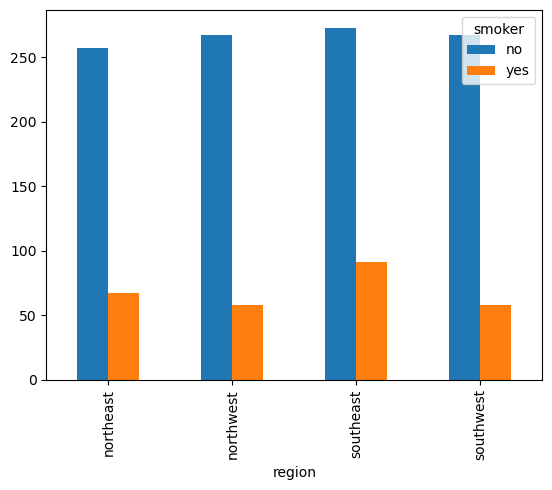

In [5]:
 contigency.plot(kind='bar')

In [8]:
# Using the chi2_contingency test 
chi2, pval, dof, exp_freq = chi2_contingency(contigency, correction = False)
print('chi-square statistic: {} , Pvalue: {} , Degree of freedom: {} ,expected frequencies: {} '.format(chi2, pval, dof, exp_freq))

if (pval < 0.05):
    print('Reject Null Hypothesis')
else:
    print('Failed to reject Null Hypothesis')

chi-square statistic: 7.343477761407071 , Pvalue: 0.06171954839170541 , Degree of freedom: 3 ,expected frequencies: [[257.65022422  66.34977578]
 [258.44544096  66.55455904]
 [289.45889387  74.54110613]
 [258.44544096  66.55455904]] 
Failed to reject Null Hypothesis


### Assignment 2

#### Is the mean BMI of women with no children, one child, and two children the same? Explain your answer with statistical evidence.

Step 1: 
        
    Define null and alternative hypotheses 
* H0: μ1 = μ2 = μ3 The mean BMI of women with no children , one child,two children is same
* Ha: Atleast one of mean BMI of women is not same
   
Step 2:

    Decide the significance level α = 0.05
    
Step 3: 
            
    Identify Test
One-way ANOVA - Equality of population through variances of samples.


Step 4: 
     
    Calculate the test-statistics and p-value


Step 5: 

    Decide to reject or accept null hypothesis
P value is 0.715858 and it is greater than aplha(0.05) ,We failed to reject the null hypothesis and conclude that mean Bmi of women with no children,one children, two children is same.

In [10]:
# Filtering data of only women with 0, 1 and 2 children
df_female = Insurance_df[Insurance_df['sex'] == 'female']
df_female_child = df_female.loc[df_female['children']<=2]
df_female_child.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92400
5,31,female,25.74,0,no,southeast,3756.62160
6,46,female,33.44,1,no,southeast,8240.58960
9,60,female,25.84,0,no,northwest,28923.13692
11,62,female,26.29,0,yes,southeast,27808.72510


In [15]:
# Calculating the average BMI for each number of children
average_bmi_by_children = df_female_child.groupby('children')['bmi'].mean()
average_bmi_by_children

children
0    30.361522
1    30.052658
2    30.649790
Name: bmi, dtype: float64

<Axes: xlabel='children', ylabel='bmi'>

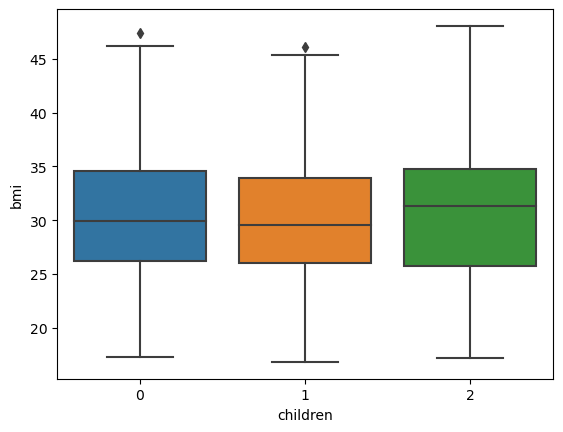

In [22]:
# Women BMI with children 0, 1, 2;
sns.boxplot(x="children", y="bmi", data=df_female_child)


In [23]:
# Applying ANOVA and cheking each children count (0,1,2) with the bmi;
formula = 'bmi ~ C(children)'
model = ols(formula, df_female_child).fit()
aov_table = anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(children),2.0,24.590123,12.295062,0.334472,0.715858
Residual,563.0,20695.661583,36.759612,NaN,NaN
